In [276]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [278]:
season = 'JFM'

### Filename for saved plots

In [279]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [280]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [281]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [282]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [283]:
from bs_fdbck.constants import path_measurement_data

## Settings: 

In [284]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [285]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [286]:
ds_smr_sat = xr.open_dataset(sat_filename)

In [287]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/19)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    OA (microgram m^-3)                         (time) float64 ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

In [288]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [289]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

In [290]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

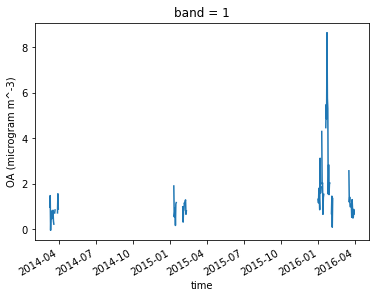

In [291]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [292]:
q33 = ds_smr_sat_JA['OA (microgram m^-3)'].quantile(0.33)
q66 = ds_smr_sat_JA['OA (microgram m^-3)'].quantile(0.66)

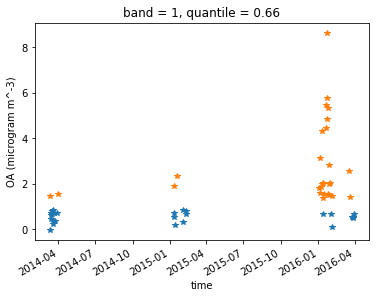

In [293]:
ds_smr_sat_JA.where(ds_smr_sat_JA['OA (microgram m^-3)']<=q33)['OA (microgram m^-3)'].plot(marker='*', linewidth=0)
ds_smr_sat_JA.where(ds_smr_sat_JA['OA (microgram m^-3)']>=q66)['OA (microgram m^-3)'].plot(marker='*', linewidth=0)

#a.isel(LAT=0,LON=0).plot(marker='*', linewidth=0)
#ds_smr_sat_JA['OA (microgram m^-3)'].isel(LAT=0,LON=0).plot(marker='*', linewidth=0)

In [294]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [295]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [296]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 630, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-01-01 ... 2018-03-31
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 216.0 192.0 169.0 ... nan nan
    CER (micrometer)     (time, LAT, LON) float32 17.54 16.1 16.06 ... nan nan
    COT                  (time, LAT, LON) float32 18.3 17.82 14.13 ... nan nan

In [297]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [298]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [299]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                          
2014-03-10 -1.5 -64.5             0.990000          62.0         18.480000   
                -59.5             0.990000          87.0         23.109999   
                -58.5             0.990000          84.0         20.480000   
                -57.5             0.990000         104.0         20.930000   
                -56.5             0.990000         115.0         19.070000   
...                                    ...           ...               ...   
2016-03-30 -7.5 -62.5             0.677056          93.0         19.340000   
                -61.5             0.677056         193.0         22.879999   
                -60.5             0.677056         284.0         23.260000   
                -59.5             0.677056         384.0         23.430000   
                -52.5             0.677056          89.0         21.260000   

                         COT  
time       LAT  LON           
2014-03-10 -1.5 -64.5   5.17  
                -59.5   5.79  
                -58.5   6.13  
                -57.5   7.83  
                -56.5   9.08  
...                      ...  
2016-03-30 -7.5 -62.5   7.34  
                -61.5  12.37  
                -60.5  17.67  
                -59.5  24.82  
                -52.5   6.80  

[3160 rows x 4 columns]

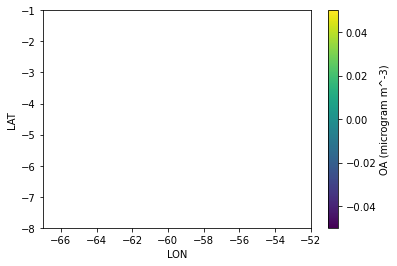

In [300]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [301]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [302]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


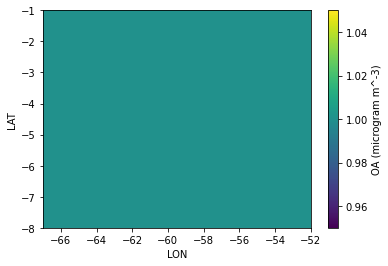

In [303]:
(~da_drop_pixels).plot()

In [304]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

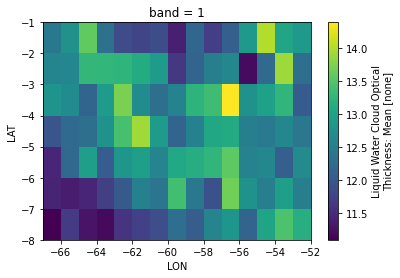

In [305]:
ds_smr_sat_JAs['COT'].mean('time').plot()

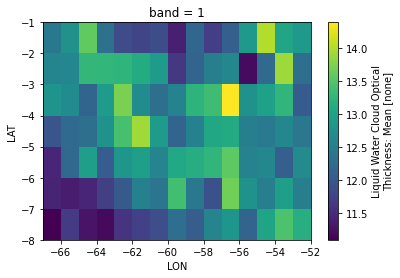

In [306]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([2520., 3780.,  840.,  315.,    0.,  315.,  315.,    0.,    0.,
         105.]),
 array([-0.04    ,  0.827862,  1.695724,  2.563586,  3.431448,  4.29931 ,
         5.167172,  6.035034,  6.902896,  7.770758,  8.63862 ]),
 <BarContainer object of 10 artists>)

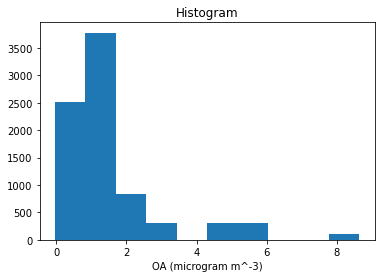

In [307]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [308]:
1-.33333

0.66667

In [309]:
ds_smr_sat_JAs.to_dataframe().dropna()['OA (microgram m^-3)'].quantile([0.3333333,.66666666]).values

array([0.85249375, 1.52768   ])

In [310]:
dic_OA_percentiles = dict()

In [311]:
[perc_33, perc_66] = ds_smr_sat_JAs.to_dataframe().dropna()['OA (microgram m^-3)'].quantile([0.3333333,.66666666]).values

dic_OA_percentiles['Observations']=dict()
dic_OA_percentiles['Observations']['33rd']=perc_33
dic_OA_percentiles['Observations']['66th']=perc_66
v = 'OA (microgram m^-3)'
dic_OA_percentiles['Observations']['med_high'] = float(ds_smr_sat_JAs[v].where(ds_smr_sat_JAs[v]>perc_66).median())
dic_OA_percentiles['Observations']['med_low']  = float(ds_smr_sat_JAs[v].where(ds_smr_sat_JAs[v]<perc_33).median())


#df_hyy_1['OA_category']

ds_smr_sat_JAs['OA_low']= ds_smr_sat_JAs['OA (microgram m^-3)']<perc_33
ds_smr_sat_JAs['OA_high']= ds_smr_sat_JAs['OA (microgram m^-3)']>perc_66

df_smr_sat_JAs = ds_smr_sat_JAs.to_dataframe()

df_smr_sat_JAs=df_smr_sat_JAs.assign(OA_category= pd.NA)
df_smr_sat_JAs.loc[df_smr_sat_JAs['OA_high'], 'OA_category'] = 'OA high'
df_smr_sat_JAs.loc[df_smr_sat_JAs['OA_low'], 'OA_category'] = 'OA low'

#ds_smr_sat_JAs['OA_category'][ds_smr_sat_JAs['OA_high']] = 'OA high'

In [312]:
v = 'OA (microgram m^-3)'

In [313]:
ds_smr_sat_JAs[v].where(ds_smr_sat_JAs[v]>perc_66).median()

<xarray.DataArray 'OA (microgram m^-3)' ()>
array(2.20192325)
Coordinates:
    band     int64 1

In [314]:
float(ds_smr_sat_JAs[v].where(ds_smr_sat_JAs[v]>perc_66).median())

2.20192325

In [315]:
ds_smr_sat_JAs['OA_category']=df_smr_sat_JAs.to_xarray()['OA_category']

In [316]:
ds_smr_sat_JAs['OA_low'].where(ds_smr_sat_JAs['OA_low']).to_dataframe().dropna().count()

band      2730
OA_low    2730
dtype: int64

In [317]:
ds_smr_sat_JAs['OA_low'].where(ds_smr_sat_JAs['OA_low']).to_dataframe().dropna().count()

band      2730
OA_low    2730
dtype: int64

In [318]:
ds_smr_sat_JAs['OA_high'].to_dataframe().dropna().count()

band       66150
OA_high    66150
dtype: int64

In [319]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [320]:
df_hyy_1

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT,OA_low,OA_high,OA_category
time,lat,lon,,,,,,,
2012-01-01,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
2012-01-02,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
2012-01-03,-7.5,-66.5,NaN,73.0,18.779999,5.89,False,False,<NA>
2012-01-04,-7.5,-66.5,NaN,114.0,18.580000,8.63,False,False,<NA>
2012-01-05,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
...,...,...,...,...,...,...,...,...,...
2018-03-27,-1.5,-52.5,NaN,202.0,23.559999,12.78,False,False,<NA>
2018-03-28,-1.5,-52.5,NaN,NaN,NaN,NaN,False,False,<NA>
2018-03-29,-1.5,-52.5,NaN,NaN,NaN,NaN,False,False,<NA>


#### Original binning from Yli-Juuti et al:

In [321]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

labels=[ 80, 120, 160, 200, 240, 280, 320]

df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
# label for each bin
df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)

#### Quantile binning

In [322]:
df_hyy_1['CWP (g m^-2)'].dropna()

time        lat   lon  
2012-01-03  -7.5  -66.5     73.0
2012-01-04  -7.5  -66.5    114.0
2012-01-06  -7.5  -66.5     60.0
2012-01-15  -7.5  -66.5    103.0
2012-01-16  -7.5  -66.5    124.0
                           ...  
2018-03-19  -1.5  -52.5    194.0
2018-03-20  -1.5  -52.5     88.0
2018-03-21  -1.5  -52.5    303.0
2018-03-27  -1.5  -52.5    202.0
2018-03-30  -1.5  -52.5    149.0
Name: CWP (g m^-2), Length: 21613, dtype: float32

In [323]:
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 7)#bins=bins, labels=labels)
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)
# Label by median in each bin
di = dict(df_hyy_1.groupby('CWP_cut').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cutlm'] = df_hyy_1['CWP_cut'].apply(lambda x:di[x])

#### Bin from 5th to 95th quantile of CWP and label by median in each bin or just number

In [324]:
n_bins = 6
labels = np.arange(n_bins)

qants = df_hyy_1['CWP (g m^-2)'].quantile([.0,.90])

bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)

bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
bins2.values[0] = pd.Interval(0,bins2[0].right)


df_hyy_1['CWP_cut2']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins2, labels=labels)


di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

df_hyy_1['CWP_cut2l'] = df_hyy_1['CWP_cut2'].apply(lambda x:di_per_lab[x])


di = dict(df_hyy_1.groupby('CWP_cut2').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lm'] = df_hyy_1['CWP_cut2'].apply(lambda x:di[x])
#di = dict(df_hyy_1.groupby('CWP_cut2').mid)
#for k in di.keys():
#    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:np.round(x.mid))


#df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:x.mid)

<AxesSubplot:ylabel='Frequency'>

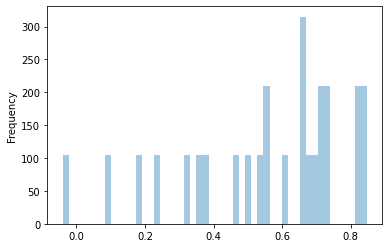

In [325]:
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')



#df_hyy_1_old['OA (microgram m^-3)'][df_hyy_1_old['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')



In [326]:
vs =['OA (microgram m^-3)', 'CWP (g m^-2)', 'CER (micrometer)', 'COT',
       'OA_low', 'OA_high', 'OA_category']

df_smr_sat_JAsad model data:

## Load model data

In [327]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 

models =[model_name_noresm,model_name_echam,model_name_ec_earth]

### Settings

In [328]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

In [329]:
l=-10
((l)%360)

350

In [330]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [331]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

### NorESM

In [332]:


lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [333]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [334]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

#### Input files

In [335]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [336]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [337]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [338]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [339]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [340]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [341]:
cases_echam = [case_name_echam]

### EC-Earth

In [342]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [343]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [344]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [345]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [346]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [347]:
cases_ec_earth = [case_name_ec_earth]

### Read in model data

In [348]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2] )

df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2] )
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2] )

In [349]:
df_mod_ec_earth.to_xarray()

<xarray.Dataset>
Dimensions:                   (time: 2558, lat: 10, lon: 22)
Coordinates:
  * time                      (time) object '2011-12-31' ... '2018-12-31'
  * lat                       (lat) float64 -7.37 -6.67 -5.96 ... -1.75 -1.05
  * lon                       (lon) float64 293.2 293.9 294.6 ... 307.3 308.0
Data variables: (12/107)
    station                   (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO'
    liq_frac_cwp              (time, lat, lon) float64 nan nan nan ... nan nan
    liq_cloud_time            (time, lat, lon) float64 nan nan nan ... nan nan
    cdnc_incld                (time, lat, lon) float64 nan nan nan ... nan nan
    tcw                       (time, lat, lon) float64 nan nan nan ... nan nan
    cl_frac_where_cltime_pos  (time, lat, lon) float64 nan nan nan ... nan nan
    ...                        ...
    N100-500_STP              (time, lat, lon) float64 nan nan ... 348.8 348.8
    M_DUCOS                   (time, lat, lon) float64 nan nan ... 5.649e-10
    M_BCCOS                   (time, lat, lon) float64 nan nan ... 1.961e-14
    DDRY_ACS                  (time, lat, lon) float64 nan nan ... 240.9 240.9
    M_SOANUS                  (time, lat, lon) float64 nan nan ... 2.046e-08
    year                      (time, lat, lon) int64 2011 2011 ... 2018 2018

## Pick out months:

In [350]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]

### Organize data in dictionary

In [351]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df['Observations'] = df_hyy_1

## Mask data

### NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top 

In [352]:
df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

### Scale CWP down for EC-Earth

In [353]:
_df = dic_df[model_name_ec_earth]
_df = _df.rename({'CWP':'CWP_orig'}, axis=1)
dic_df[model_name_ec_earth]  = _df

In [354]:
_df = dic_df[model_name_ec_earth]

if 'scaled' not in _df.columns:
    _df['CWP'] = _df['CWP_orig']*.7
    
    _df['scaled'] = True
dic_df[model_name_ec_earth]  = _df

## Rename variables:


In [355]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    
    
}
rn_dic_ec_earth = {
    
  # 'tclw':'CWP',
}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}



In [356]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',
    

}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
}

In [357]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    'Observations': rn_dic_obs
}

#### Fix NorESM having OA as well as OA_STP

In [358]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'Observations'])

In [359]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    if ('OA' in dic_df[mod].columns) & ('OA_STP' in dic_df[mod].columns):
        if ('OA_STP' in _rn_dic):
            if (_rn_dic['OA_STP']=='OA'):
                dic_df[mod] = dic_df[mod].drop(['OA'], axis=1)
                print('dropping OA in favor of OA_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

dropping OA in favor of OA_STP


In [360]:
for key, rn in zip([model_name_noresm, model_name_echam, model_name_ec_earth,'Observations'], 
                   [rn_dic_noresm, rn_dic_echam,rn_dic_ec_earth, rn_dic_obs]):
    dic_df[key] = dic_df[key].rename(rn, axis=1)

## Group by cloud water path 

#### Predefined bins

In [361]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

### Bin model data:

CWP above 50. 

In [362]:
varl_categories = ['OA']#,'CLDFREE']

In [363]:
varl_categories

['OA']

In [364]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'Observations'])

In [365]:
dic_df['EC-Earth'][['CWP']]

CWP
time       lat   lon               
2012-01-01 -7.37 293.20         NaN
                 293.91         NaN
                 294.61         NaN
                 295.31         NaN
                 296.02         NaN
...                             ...
2018-03-31 -1.05 305.16  202.471920
                 305.86  336.627200
                 306.56  165.802182
                 307.27  167.852741
                 307.97  164.090668

[139040 rows x 1 columns]

In [366]:
ds_ec = dic_df['EC-Earth']#.to_xarray()

In [367]:
ds_no = dic_df['NorESM'].to_xarray()

In [368]:
7*12/(10*22)

0.38181818181818183

In [369]:
ds_no

<xarray.Dataset>
Dimensions:            (time: 579, lat: 7, lon: 12)
Coordinates:
  * time               (time) object '2012-01-03' '2012-01-04' ... '2018-03-31'
  * lat                (lat) float64 -7.068 -6.126 -5.183 ... -2.356 -1.414
  * lon                (lon) float64 293.8 295.0 296.2 ... 305.0 306.2 307.5
Data variables: (12/100)
    station            (time, lat, lon) object nan nan nan ... 'ATTO' nan nan
    FCTI               (time, lat, lon) float64 nan nan nan nan ... 0.0 nan nan
    FLNT_DRF           (time, lat, lon) float64 nan nan nan ... 249.9 nan nan
    CLDTOT             (time, lat, lon) float64 nan nan nan ... 0.6349 nan nan
    FSDSCDRF           (time, lat, lon) float64 nan nan nan ... 659.9 nan nan
    FSNT               (time, lat, lon) float64 nan nan nan ... 560.3 nan nan
    ...                 ...
    N100_STP           (time, lat, lon) float64 nan nan nan ... 976.3 nan nan
    SO4_PR             (time, lat, lon) float64 nan nan nan ... 0.00509 nan nan
    SOA_A1             (time, lat, lon) float64 nan nan nan ... 2.718 nan nan
    OA                 (time, lat, lon) float64 nan nan nan ... 2.976 nan nan
    year               (time, lat, lon) float64 nan nan nan ... nan nan
    mask_liq_cloudtop  (time, lat, lon) object nan nan nan nan ... True nan nan

In [370]:
n_bins = 6

for model_name in models:
    print(model_name)
    df_mod = dic_df[model_name]
    

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.90])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)
 
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)
        
        q66 = df_mod[v].quantile(.6666666)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()

        print(q66)
        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( df_mod[v].quantile(.34)<df_mod[v]) & (df_mod[v]<df_mod[v].quantile(.66))
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'
        dic_df[model_name] = df_mod

NorESM
4.668271372439266
7.453860039311746
ECHAM-SALSA
1.3099047
2.63975205
EC-Earth
2.669071003871663
3.4139074030202217


In [371]:
OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)
print(fn) 
OA_percentile_df

Plots/cloud_props__percentile_OA_OA_perc_JFM.csv


,33rd,66th,med_high,med_low,diff
Observations,0.852494,1.527680,2.201923,0.637500,0.675186
NorESM,4.668271,7.453860,9.806378,3.623280,2.785589
ECHAM-SALSA,1.309905,2.639752,3.567192,0.838221,1.329847
EC-Earth,2.669071,3.413907,3.983732,2.323572,0.744836


## Quantile cut

In [372]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [373]:
palette = 'Set2'

In [374]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

In [375]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
420
NorESM
357
EC-Earth
180
Observations
48


21613
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count_JFM.png


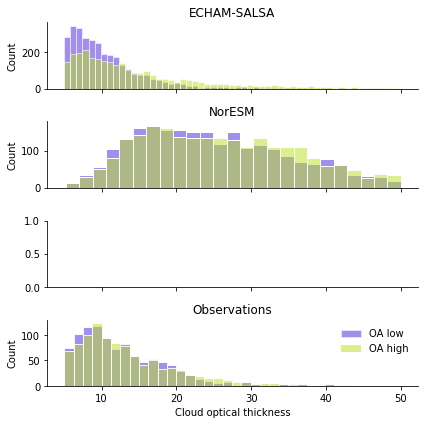

In [376]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key=='EC-Earth':
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



21487
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


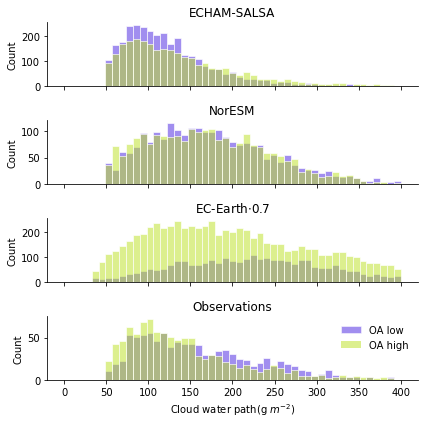

In [377]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,400)
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1010
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


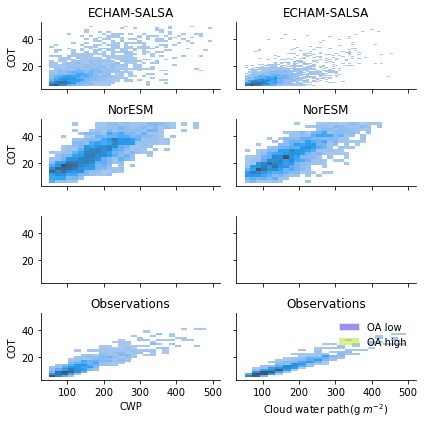

In [378]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    if key=='EC-Earth':
        continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1010
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


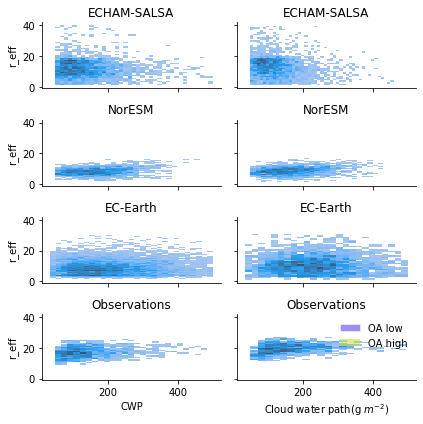

In [379]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'r_eff'
x_cut = 500
y_cut = 40
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    #if key=='EC-Earth':
    #    continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_y]<y_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [380]:
hue_v = 'OA high'

21487
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


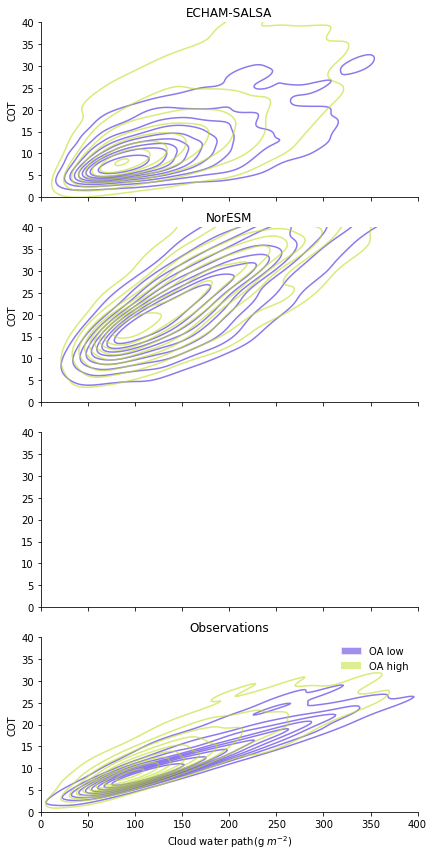

In [381]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key=='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,40])    

21613
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_JFM.png


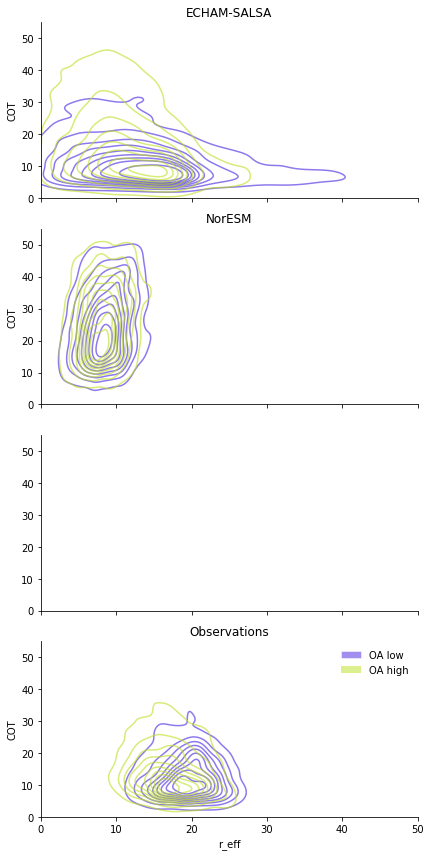

In [382]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'r_eff'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key =='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel(v_x)
ax.set_ylabel(v_y)

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,50])
    ax.set_ylim([0,55])    

21487
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


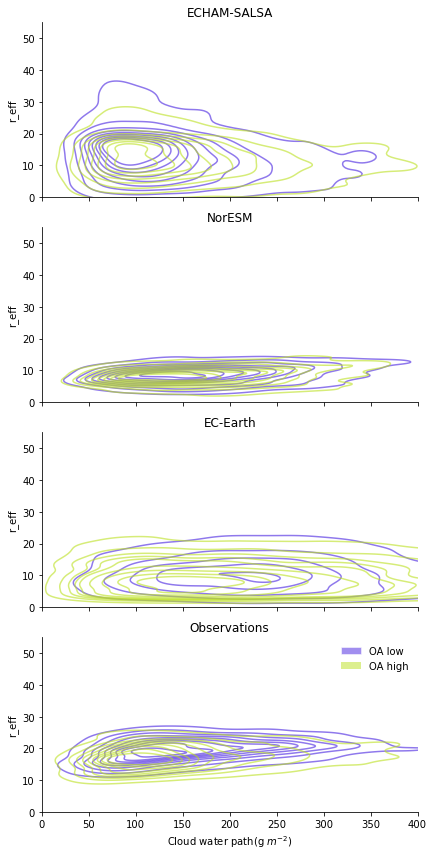

In [383]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_y = 'r_eff'
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,55])    

In [384]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

8853

In [385]:
len(dic_df['ECHAM-SALSA'].dropna())

5548

In [386]:
len(dic_df['NorESM'].dropna())

4534

8853
7058
14767
21613
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_JFM.png


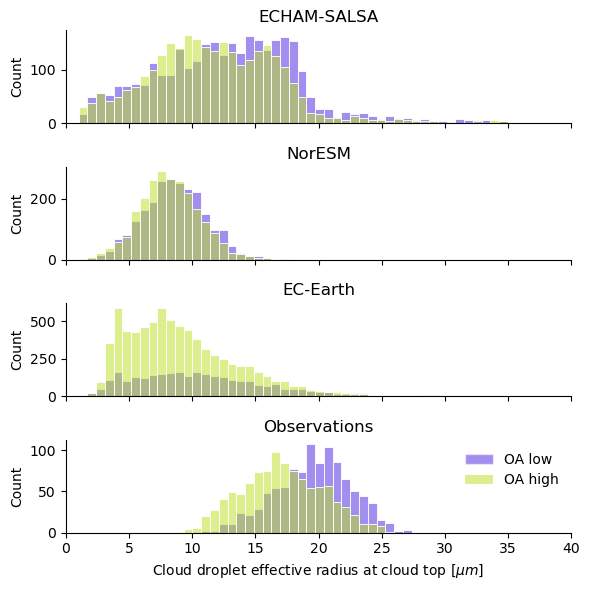

In [387]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
_bins = np.linspace(1, 35)
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [388]:
df_ec_earth = dic_df['EC-Earth']
df_ec_earth = df_ec_earth[df_ec_earth['r_eff']>=5]
dic_df['EC-Earth'] = df_ec_earth

In [389]:
ds_ech = dic_df['ECHAM-SALSA'].to_xarray()

In [390]:
ds_nor = dic_df['NorESM'].to_xarray()

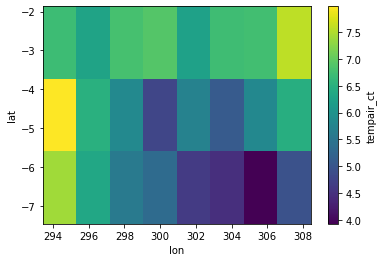

In [391]:
(ds_ech['tempair_ct'].mean('time')-273.15).plot()

In [392]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) object '2012-01-01' '2012-01-02' ... '2018-03-31'
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_ct_incld  (time, lat, lon) float64 1.403e+06 1.555e+06 ... 5.973e+06
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    tempair_ct      (time, lat, lon) float64 284.0 283.7 260.7 ... 283.1 281.1
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    cwp             (time, lat, lon) float64 79.64 63.86 124.4 ... 78.97 70.64
    ...              ...
    OA_low          (time, lat, lon) bool True True True True ... True True True
    OA_high         (time, lat, lon) bool False False False ... False False
    OA_mid_range    (time, lat, lon) bool False False False ... False False
    OA_category     (time, lat, lon) object 'OA low' 'OA low' ... 'OA low'
    CWP_qcut        (time, lat, lon) object (76.338, 95.436] ... (50.01300000...
    CWP_qcutl       (time, lat, lon) float64 85.89 63.18 130.0 ... 85.89 63.18

In [393]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) object '2012-01-01' '2012-01-02' ... '2018-03-31'
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_ct_incld  (time, lat, lon) float64 1.403e+06 1.555e+06 ... 5.973e+06
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    tempair_ct      (time, lat, lon) float64 284.0 283.7 260.7 ... 283.1 281.1
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    cwp             (time, lat, lon) float64 79.64 63.86 124.4 ... 78.97 70.64
    ...              ...
    OA_low          (time, lat, lon) bool True True True True ... True True True
    OA_high         (time, lat, lon) bool False False False ... False False
    OA_mid_range    (time, lat, lon) bool False False False ... False False
    OA_category     (time, lat, lon) object 'OA low' 'OA low' ... 'OA low'
    CWP_qcut        (time, lat, lon) object (76.338, 95.436] ... (50.01300000...
    CWP_qcutl       (time, lat, lon) float64 85.89 63.18 130.0 ... 85.89 63.18

In [394]:
ds_nor['COT'].count()

<xarray.DataArray 'COT' ()>
array(7058)

In [395]:
ds_ech.where(ds_ech['cl_time_ct']>.9)['COT'].count()

<xarray.DataArray 'COT' ()>
array(5112)

In [396]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) object '2012-01-01' '2012-01-02' ... '2018-03-31'
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_ct_incld  (time, lat, lon) float64 1.403e+06 1.555e+06 ... 5.973e+06
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    tempair_ct      (time, lat, lon) float64 284.0 283.7 260.7 ... 283.1 281.1
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    cwp             (time, lat, lon) float64 79.64 63.86 124.4 ... 78.97 70.64
    ...              ...
    OA_low          (time, lat, lon) bool True True True True ... True True True
    OA_high         (time, lat, lon) bool False False False ... False False
    OA_mid_range    (time, lat, lon) bool False False False ... False False
    OA_category     (time, lat, lon) object 'OA low' 'OA low' ... 'OA low'
    CWP_qcut        (time, lat, lon) object (76.338, 95.436] ... (50.01300000...
    CWP_qcutl       (time, lat, lon) float64 85.89 63.18 130.0 ... 85.89 63.18

(array([1., 2., 1., 2., 5., 3., 3., 2., 2., 3.]),
 array([0.83014113, 0.83874669, 0.84735225, 0.85595781, 0.86456337,
        0.87316894, 0.8817745 , 0.89038006, 0.89898562, 0.90759118,
        0.91619674]),
 <BarContainer object of 10 artists>)

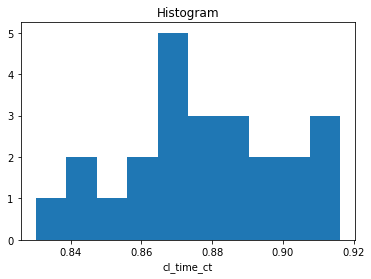

In [397]:
(ds_ech['cl_time_ct'].mean('time')).plot.hist()#vmin=100, vmax=160)

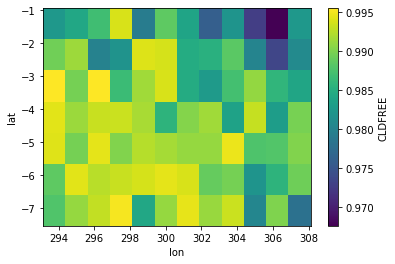

In [398]:
(1-ds_nor['CLDFREE'].mean('time')).plot()

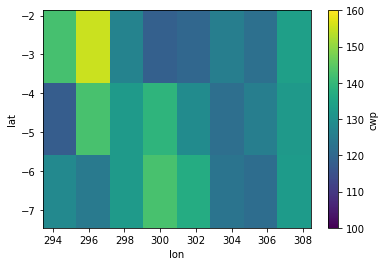

In [399]:
(ds_ech['cwp'].mean('time')).plot(vmin=100, vmax=160)

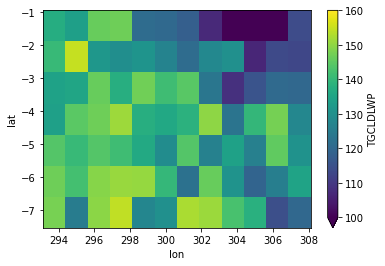

In [400]:
(ds_nor['TGCLDLWP'].mean('time')).plot(vmin=100, vmax=160)

In [401]:
dic_df[model_name_echam] = dic_df[model_name_echam][dic_df[model_name_echam]['cl_time_ct']>0.9]
dic_df[model_name_echam]

station  lcdnc_ct_incld  lcdnc_ct_cm3  \
time       lat       lon                                             
2012-01-01 -2.797890 294.375    ATTO       9650340.0      9.650340   
                     298.125    ATTO       4669167.5      4.669168   
                     300.000    ATTO      18118134.0     18.118134   
           -4.663150 294.375    ATTO      19818142.0     19.818142   
                     296.250    ATTO       2674628.0      2.674628   
...                              ...             ...           ...   
2018-03-31 -2.797890 307.500    ATTO       5973303.0      5.973303   
           -4.663150 294.375    ATTO        944759.8      0.944760   
                     300.000    ATTO       1650406.2      1.650406   
                     301.875    ATTO       3435237.8      3.048498   
           -6.528409 307.500    ATTO       3542785.0      2.806612   

                              tempair_ct      ceff         cwp        COT  \
time       lat       lon                                                    
2012-01-01 -2.797890 294.375   278.41895  0.000000  224.435970  19.230902   
                     298.125   279.61798  0.000000   59.977024   8.856040   
                     300.000   292.71362  0.000000   53.875362   6.757799   
           -4.663150 294.375   277.53113  0.000000  110.907470  13.080102   
                     296.250   278.64960  0.000000  183.139000  15.567183   
...                                  ...       ...         ...        ...   
2018-03-31 -2.797890 307.500   281.09885  0.000000   70.640656   9.660858   
           -4.663150 294.375   294.66116  0.000015  100.862140   8.513659   
                     300.000   280.91270  0.000000   61.215607   6.207031   
                     301.875   277.95367  0.000000   76.662080   5.342538   
           -6.528409 307.500   278.97537  0.000000  129.151900  12.504495   

                                 lcdnc_cm3    ceff_ct     clfr  ...  \
time       lat       lon                                        ...   
2012-01-01 -2.797890 294.375  4.430701e-35  16.343527  0.00000  ...   
                     298.125  6.922904e-35  16.791536  0.00000  ...   
                     300.000 -5.966645e-36  12.863009  0.00000  ...   
           -4.663150 294.375  8.677470e-35  18.670422  0.00000  ...   
                     296.250 -3.861240e-36  16.673183  0.00000  ...   
...                                    ...        ...      ...  ...   
2018-03-31 -2.797890 307.500  1.053118e-34  17.325369  0.00000  ...   
           -4.663150 294.375  2.523887e+01  17.936687  0.42934  ...   
                     300.000  5.490066e-35  17.411081  0.00000  ...   
                     301.875  4.334511e-35  16.391298  0.00000  ...   
           -6.528409 307.500  1.442527e-34   4.974741  0.00000  ...   

                                                              CWP_cut2  \
time       lat       lon                                                 
2012-01-01 -2.797890 294.375                 (194.17718733333336, inf]   
                     298.125                  (0.0, 78.84634466666668]   
                     300.000                  (0.0, 78.84634466666668]   
           -4.663150 294.375  (107.67905533333334, 136.51176600000002]   
                     296.250  (165.34447666666668, 194.17718733333336]   
...                                                                ...   
2018-03-31 -2.797890 307.500                  (0.0, 78.84634466666668]   
           -4.663150 294.375   (78.84634466666668, 107.67905533333334]   
                     300.000                  (0.0, 78.84634466666668]   
                     301.875   (78.84634466666668, 107.67905533333334]   
           -6.528409 307.500  (107.67905533333334, 136.51176600000002]   

                              CWP_cut2l  CWP_cut2lm  CWP_cut2lmid  OA_low  \
time       lat       lon                                                    
2012-01-01 -2.797890 294.375          5         240           inf    True  

In [402]:
dic_df[model_name_echam] = dic_df[model_name_echam][dic_df[model_name_echam]['r_eff']>5]

# Calculate difference between high OA and low


In [403]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [404]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [405]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [406]:
from sklearn.utils import resample

## Bootstrap resampling 

In [407]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [408]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 1000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key =='EC-Earth') and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
420
length of 67 is 268 and 341
number of days is 137 and 165
1000
length of 93 is 360 and 392
number of days is 169 and 163
1000
length of 121 is 297 and 305
number of days is 145 and 153
1000
length of 150 is 159 and 235
number of days is 106 and 131
1000
length of 179 is 100 and 160
number of days is 75 and 111
1000
length of 240 is 158 and 347
number of days is 105 and 144
1000
NorESM
Total number of days:
373
length of 73 is 242 and 307
number of days is 91 and 115
1000
length of 108 is 405 and 401
number of days is 129 and 138
1000
length of 145 is 476 and 424
number of days is 130 and 144
1000
length of 181 is 435 and 420
number of days is 133 and 137
1000
length of 218 is 335 and 351
number of days is 124 and 134
1000
length of 276 is 458 and 449
number of days is 133 and 138
1000
EC-Earth
Observations
Total number of days:
48
length of 75 is 137 and 208
number of days is 22 and 21
1000
length of 105 is 235 and 281
number of days is 25 and 21
1

In [409]:
v = 'COT'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
2.65050491713645
NorESM
0.7833208205400816
Observations
2.16435518316422


In [410]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
Observations


# Final plot: 

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_JFM.png


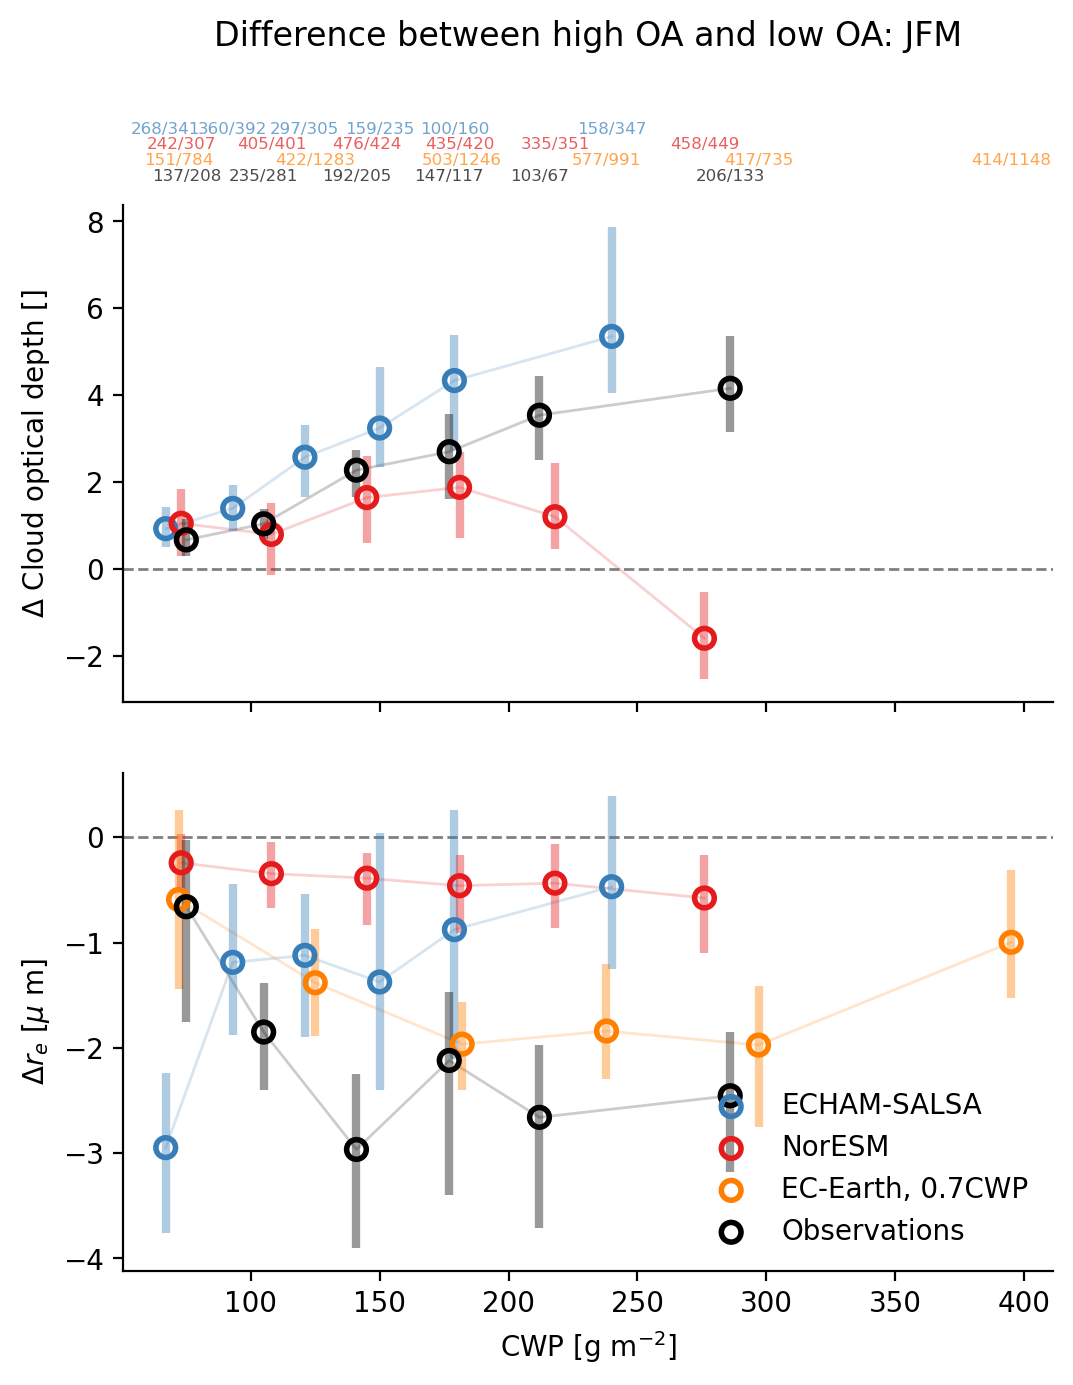

In [411]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.7CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [412]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [413]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_JFM.png


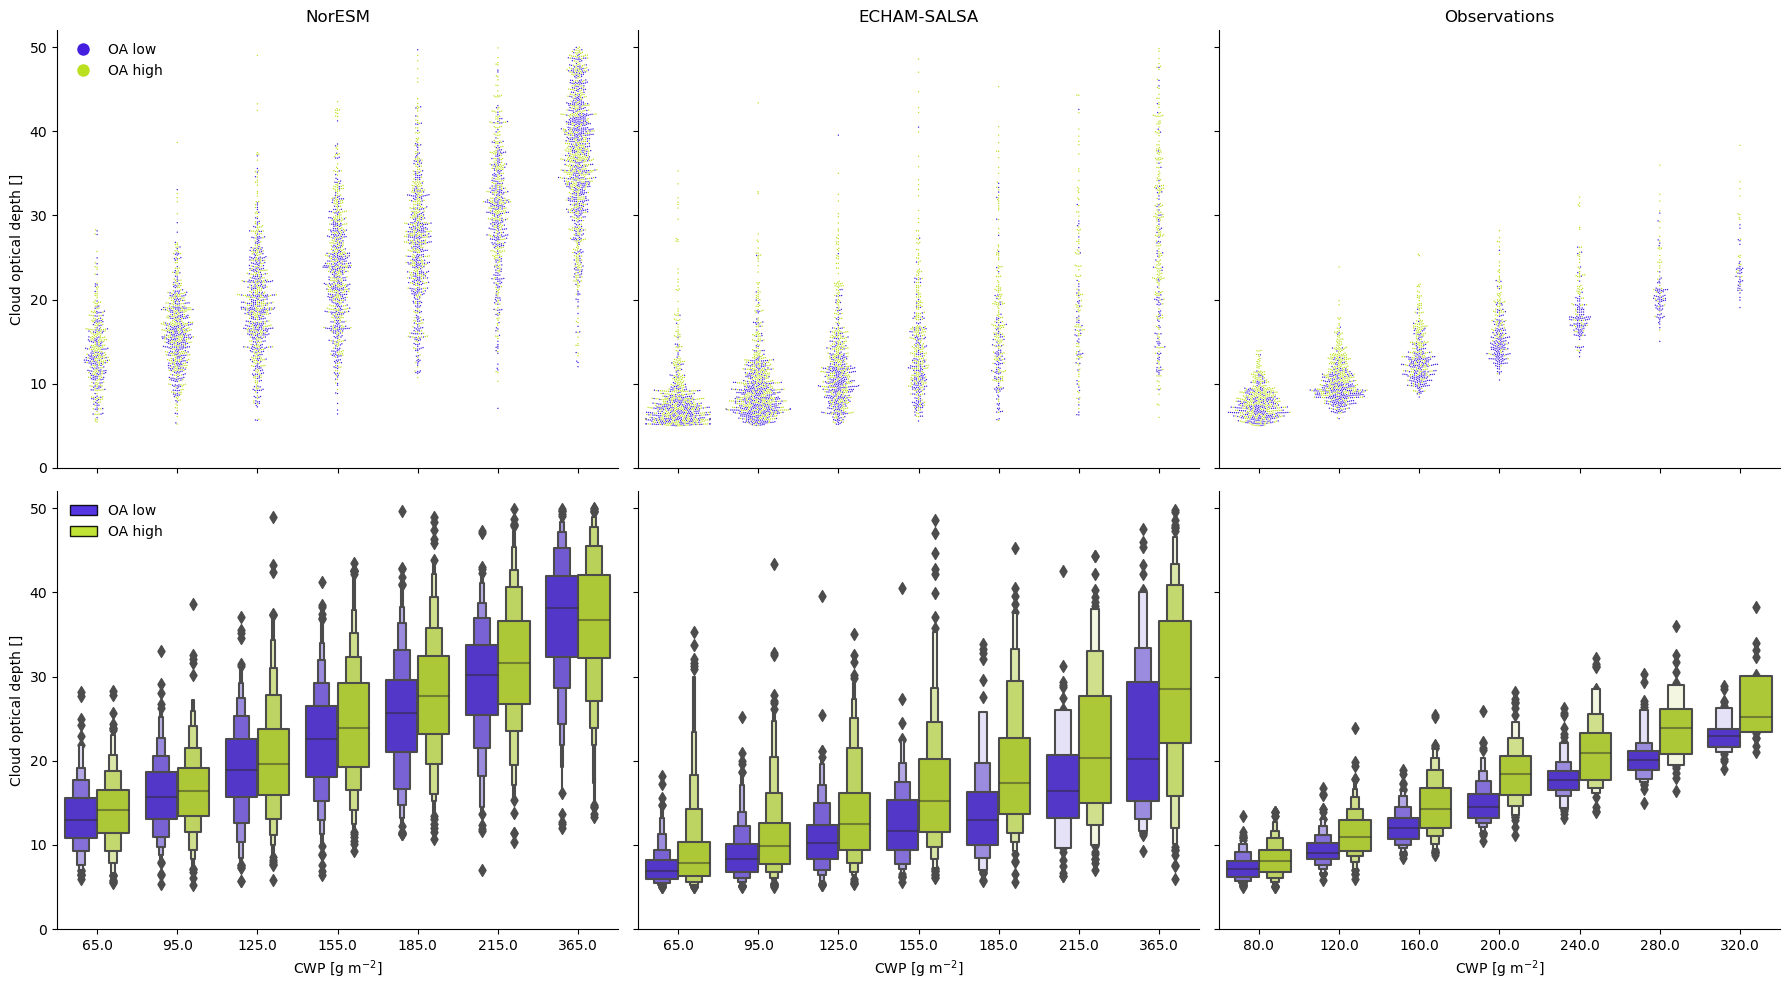

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_JFM.png


In [414]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFM.png


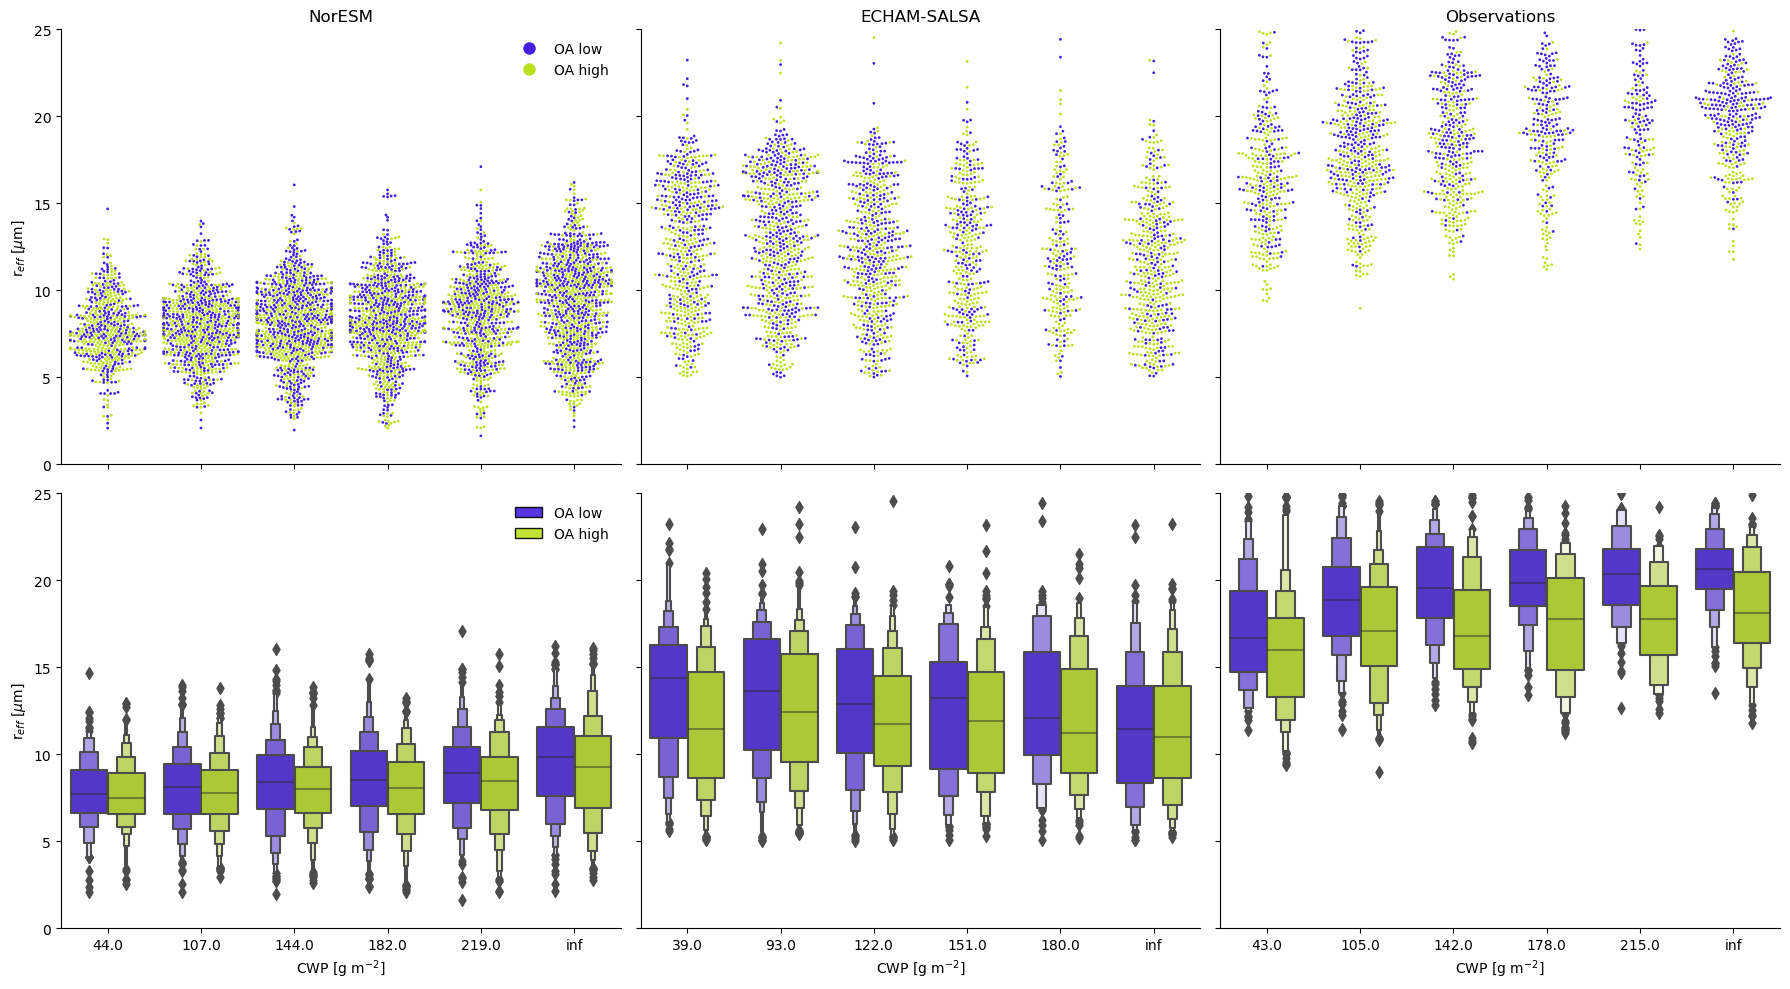

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFM.png


In [415]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFM.png


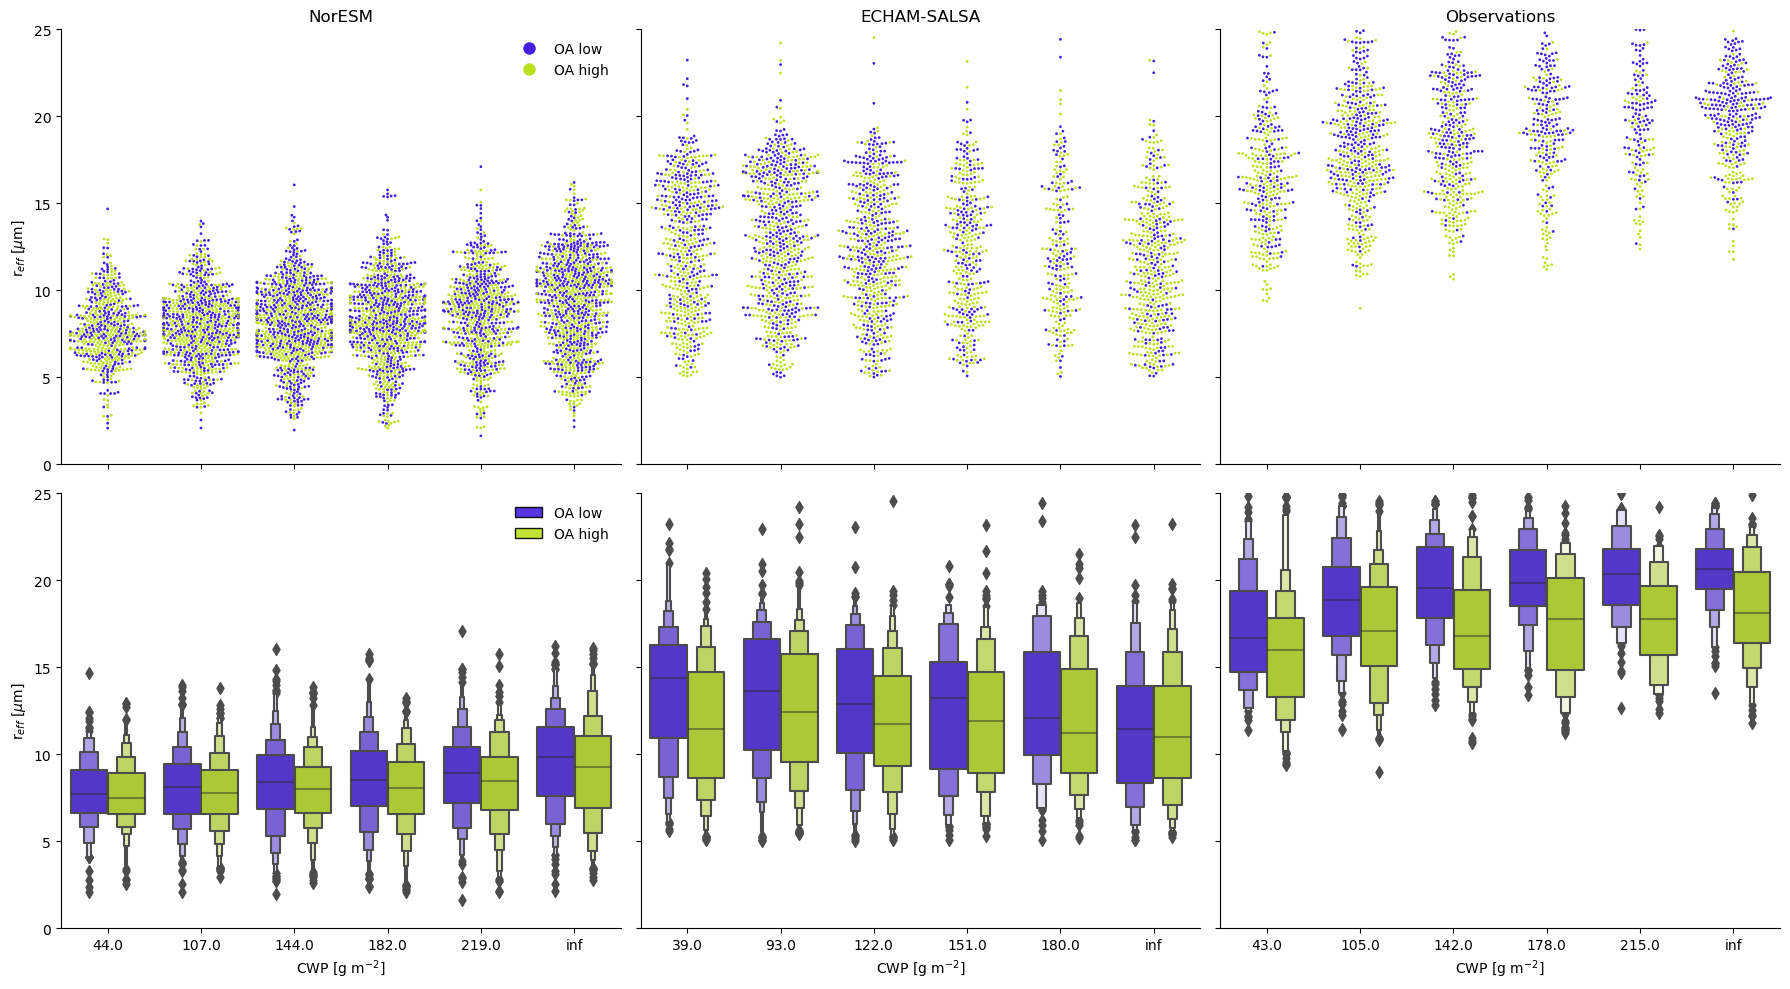

In [416]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

length of 68 is 280 and 365
number of days is 140 and 171
10000
length of 94 is 373 and 393
number of days is 171 and 161
10000
length of 124 is 290 and 310
number of days is 146 and 156
10000
length of 153 is 156 and 234
number of days is 103 and 132
10000
length of 184 is 96 and 161
number of days is 69 and 105
10000
length of 215 is 51 and 102
number of days is 46 and 72
10000
length of 274 is 91 and 213
number of days is 68 and 109
10000


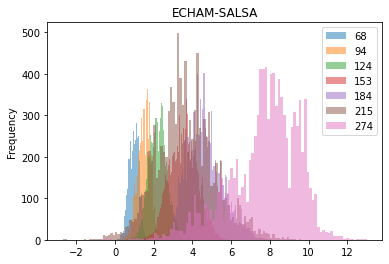

length of 67 is 172 and 222
number of days is 81 and 95
10000
length of 95 is 299 and 311
number of days is 112 and 119
10000
length of 126 is 368 and 336
number of days is 118 and 133
10000
length of 155 is 373 and 349
number of days is 124 and 135
10000
length of 184 is 343 and 331
number of days is 125 and 123
10000
length of 215 is 273 and 288
number of days is 116 and 123
10000
length of 270 is 523 and 515
number of days is 141 and 147
10000


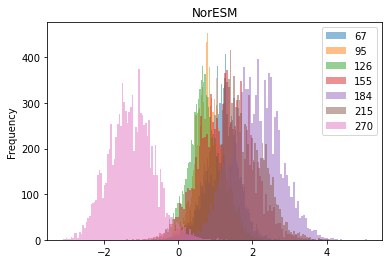

KeyError: 'COT'

In [417]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()